# Imports

In [58]:
import pickle
import pandas as pd
import numpy as np

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
from numpy import mean
from numpy import std

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = [20, 10]

# custom functions
import sys
sys.path.append(r"C:\Users\User\Documents\projects\LHL_final_project_influenza_forecasting\src")
from evaluate_model import *
from ADF import *
from arima_model import *
from rf_model import *

# set random seed
seed_value = 2022

# Datasets

In [2]:
df_time_features_pre_COVID = pickle.load(open(r"..\data\flu_cases\df_time_features_pre_COVID.pkl", "rb" ))
df_time_features = pickle.load(open(r"..\data\flu_cases\df_time_features.pkl", "rb" ))

In [3]:
df_time_features_pre_COVID.head()

,y1,y2,y3,y4,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,season_Spring,season_Summer,season_Winter
0,9.0,18.0,15.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
1,18.0,15.0,29.0,59.0,9.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2,15.0,29.0,59.0,50.0,18.0,9.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
3,29.0,59.0,50.0,37.0,15.0,18.0,9.0,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
4,59.0,50.0,37.0,26.0,29.0,15.0,18.0,9.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_time_features_pre_COVID.dropna(inplace=True)
df_time_features_pre_COVID = df_time_features_pre_COVID.reset_index(drop=True)
df_time_features_pre_COVID

,y1,y2,y3,y4,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,season_Spring,season_Summer,season_Winter
0,2.0,18.0,23.0,44.0,13.0,13.0,8.0,9.0,7.0,18.0,...,0,0,0,0,0,0,1,0,0,0
1,18.0,23.0,44.0,63.0,2.0,13.0,13.0,8.0,9.0,7.0,...,0,0,0,0,0,0,1,0,0,0
2,23.0,44.0,63.0,56.0,18.0,2.0,13.0,13.0,8.0,9.0,...,0,0,0,0,0,0,1,0,0,0
3,44.0,63.0,56.0,42.0,23.0,18.0,2.0,13.0,13.0,8.0,...,0,0,0,0,0,0,1,0,0,0
4,63.0,56.0,42.0,71.0,44.0,23.0,18.0,2.0,13.0,13.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,4789.0,4654.0,3989.0,3656.0,4182.0,3549.0,3811.0,3845.0,3126.0,2206.0,...,0,0,0,0,0,0,0,0,0,1
179,4654.0,3989.0,3656.0,3576.0,4789.0,4182.0,3549.0,3811.0,3845.0,3126.0,...,0,0,0,0,0,0,0,0,0,1
180,3989.0,3656.0,3576.0,3404.0,4654.0,4789.0,4182.0,3549.0,3811.0,3845.0,...,0,0,0,0,0,0,0,0,0,1
181,3656.0,3576.0,3404.0,2991.0,3989.0,4654.0,4789.0,4182.0,3549.0,3811.0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
df_time_features_pre_COVID.columns

Index(['y1', 'y2', 'y3', 'y4', 't - 1', 't - 2', 't - 3', 't - 4', 't - 5',
       't - 6', 't - 7', 'this week last year', 'two-week moving average',
       'expanding mean', 'year_2016', 'year_2017', 'year_2018', 'year_2019',
       'year_2020', 'year_2021', 'year_2022', 'month_10', 'month_11',
       'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'season_Spring', 'season_Summer',
       'season_Winter'],
      dtype='object')

In [6]:
train_size = int(len(df_time_features_pre_COVID) *.7)
test_size = len(df_time_features_pre_COVID) - train_size
train, test = df_time_features_pre_COVID[0:train_size], df_time_features_pre_COVID[train_size:len(df_time_features_pre_COVID)]

In [7]:
train_y = train[['y1','y2','y3','y4']]
train_X = train.drop(columns=['y1','y2','y3','y4'])
test_y = test[['y1','y2','y3','y4']]
test_X = test.drop(columns=['y1','y2','y3','y4'])

In [8]:
train_X.columns

Index(['t - 1', 't - 2', 't - 3', 't - 4', 't - 5', 't - 6', 't - 7',
       'this week last year', 'two-week moving average', 'expanding mean',
       'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020',
       'year_2021', 'year_2022', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'season_Spring', 'season_Summer', 'season_Winter'],
      dtype='object')

In [9]:
train_X_to_scale = train_X.loc[:,'t - 1':'expanding mean']
test_X_to_scale = test_X.loc[:,'t - 1':'expanding mean']
train_X_not_to_scale = train_X.loc[:,'year_2016':].to_numpy()
test_X_not_to_scale = test_X.loc[:,'year_2016':].to_numpy()

In [10]:
from sklearn.preprocessing import MinMaxScaler

# scale data
scaler = MinMaxScaler()
train_X_to_scale = scaler.fit_transform(train_X_to_scale)
test_X_to_scale = scaler.transform(test_X_to_scale)

In [11]:
train_X = np.concatenate((train_X_to_scale, train_X_not_to_scale),axis=1)
test_X = np.concatenate((test_X_to_scale, test_X_not_to_scale),axis=1)

In [12]:
# multioutput regression:Predict two or more numeric outputs given an input.https://machinelearningmastery.com/multi-output-regression-models-with-python/

# Linear Regression

In [13]:
model = LinearRegression()

model.fit(train_X, train_y)

LinearRegression()

In [14]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)

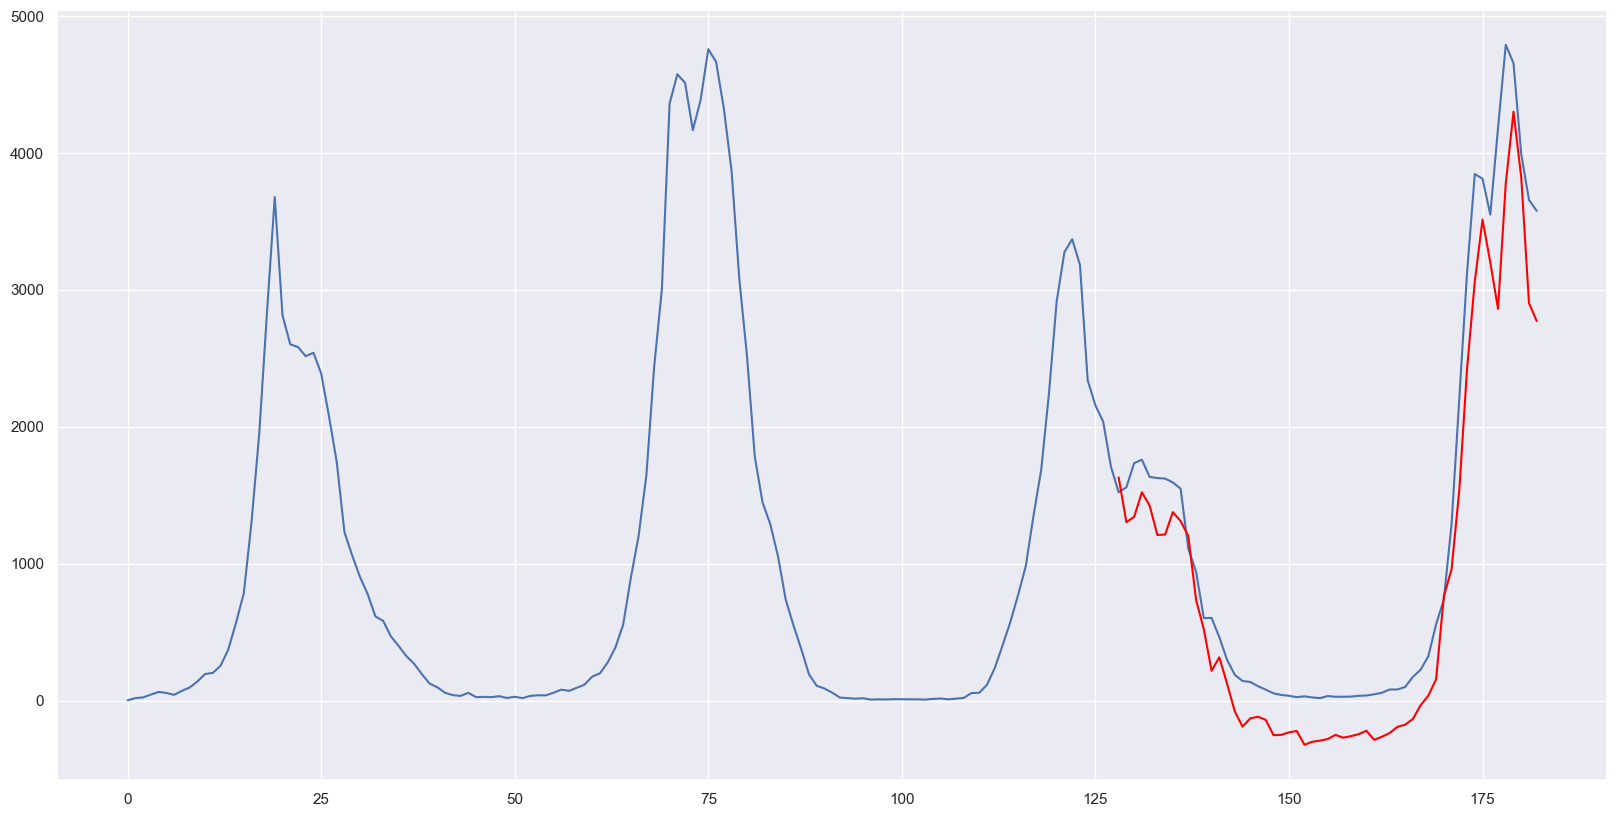

In [15]:
# predict for train and test sets
preds_test = model.predict(test_X)
preds_train = model.predict(train_X)

# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [16]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 79332.513
RMSE_train: 274.22
MAE_train: 174.413
MSE_test: 769936.619
RMSE_test: 838.041
MAE_test: 736.928


# Decision Tree Regression

In [17]:
model = DecisionTreeRegressor()

model.fit(train_X, train_y)

DecisionTreeRegressor()

In [18]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)

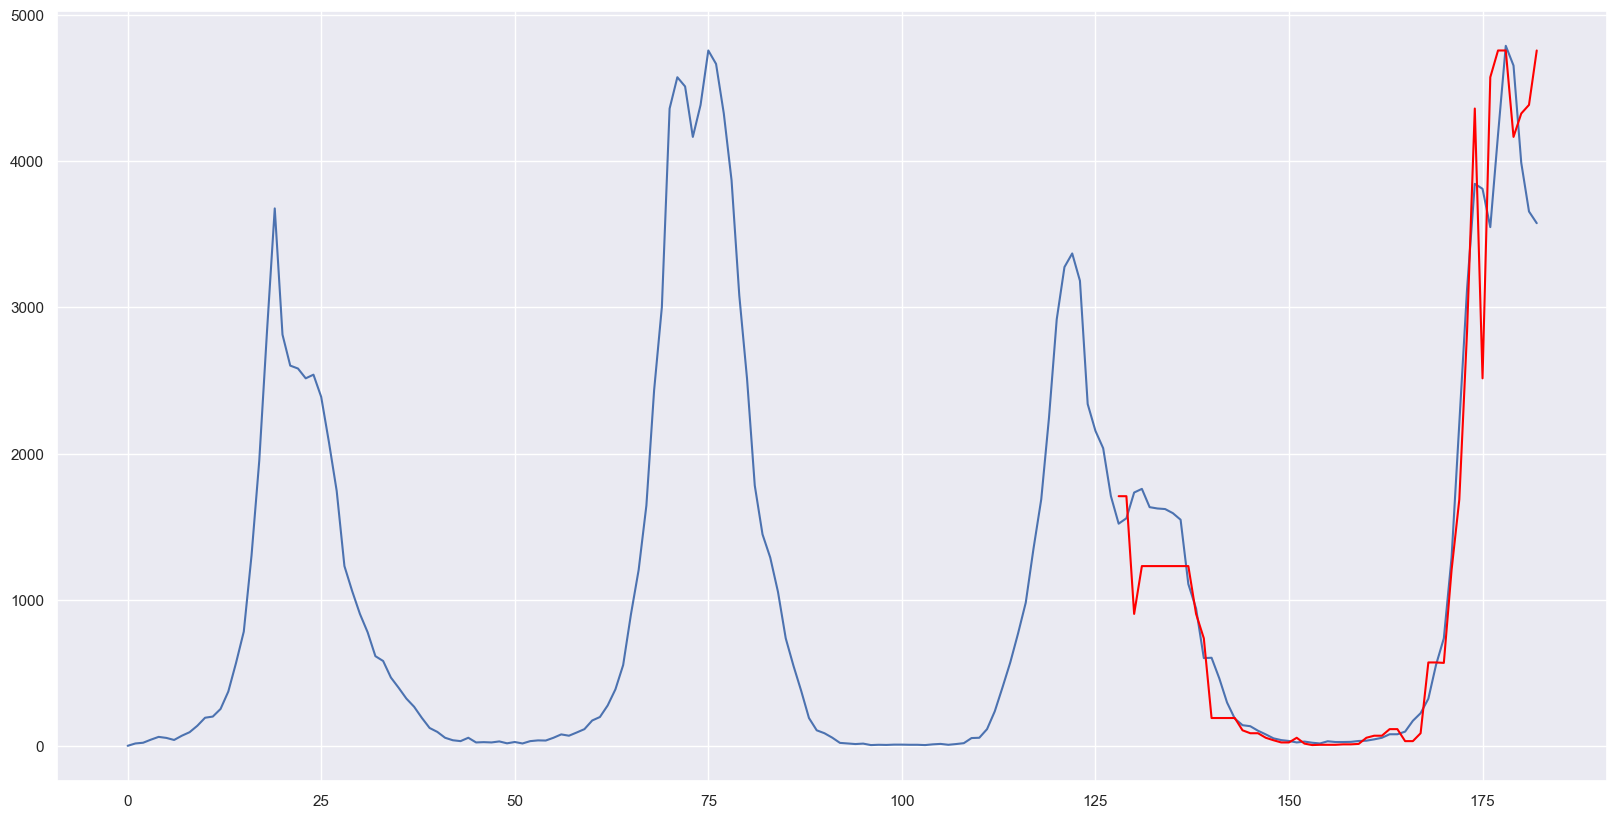

In [19]:
# predict for train and test sets
preds_test = model.predict(test_X)
preds_train = model.predict(train_X)

# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [20]:
preds_test_df.head()

,y1,y2,y3,y4
0,1709.0,1521.0,1558.0,1734.0
1,1709.0,1521.0,1558.0,1734.0
2,904.0,778.0,615.0,582.0
3,1231.0,1060.0,904.0,778.0
4,1231.0,1060.0,904.0,778.0


In [21]:
test_y.head()

,y1,y2,y3,y4
128,1521.0,1558.0,1734.0,1759.0
129,1558.0,1734.0,1759.0,1634.0
130,1734.0,1759.0,1634.0,1625.0
131,1759.0,1634.0,1625.0,1621.0
132,1634.0,1625.0,1621.0,1593.0


In [22]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 391.828 (156.694)


In [23]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 0.0
RMSE_train: 0.0
MAE_train: 0.0
MSE_test: 267585.768
RMSE_test: 504.147
MAE_test: 307.086


# K-Nearest Neighbours Regression

In [24]:
model = KNeighborsRegressor()

model.fit(train_X, train_y)

KNeighborsRegressor()

In [25]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)

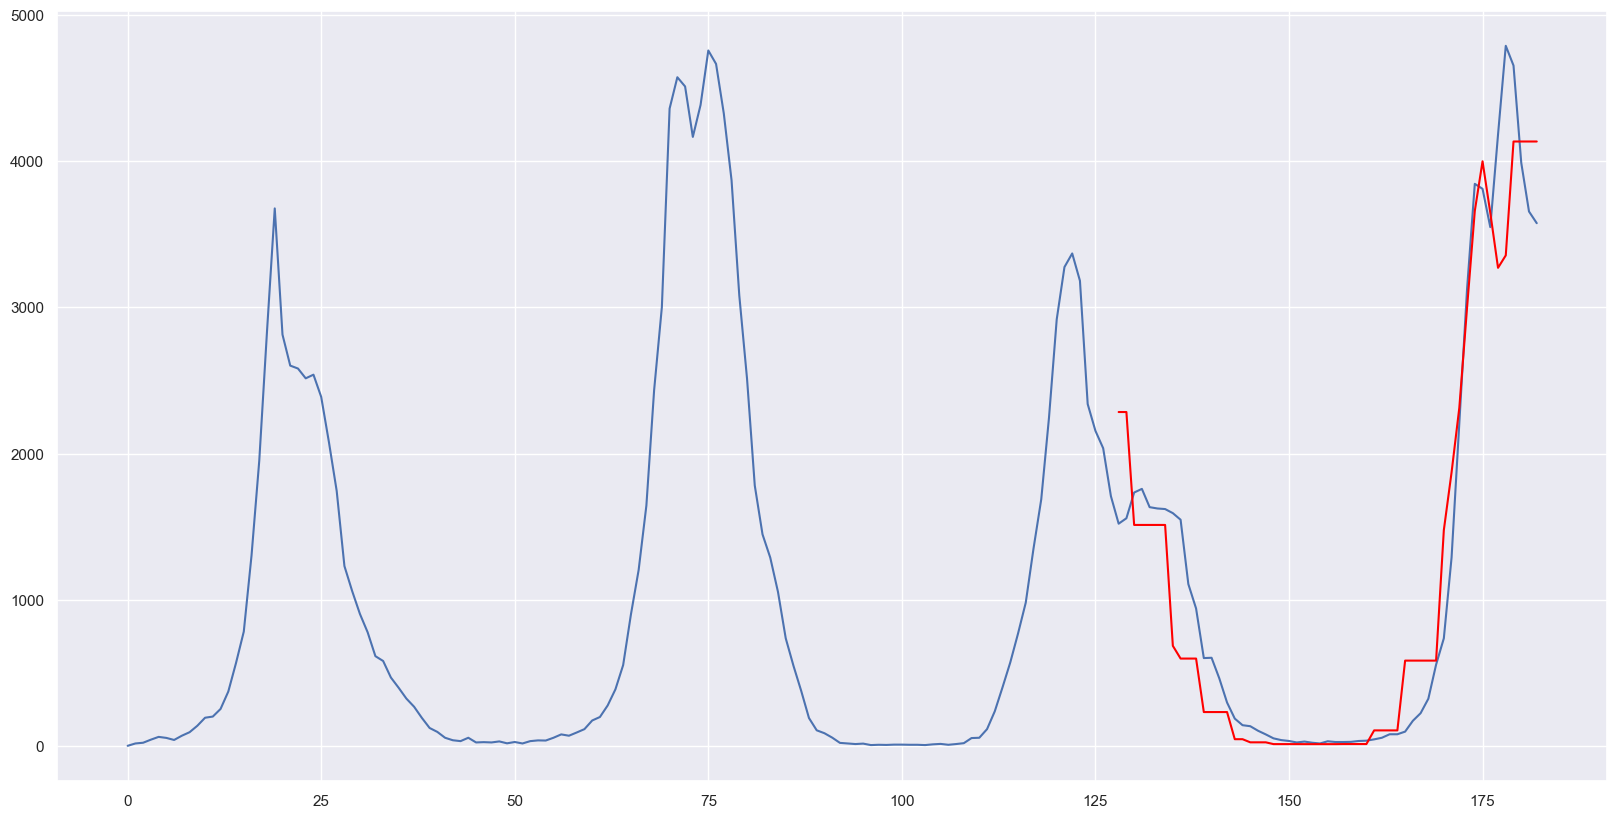

In [26]:
# predict for train and test sets
preds_test = model.predict(test_X)
preds_train = model.predict(train_X)

# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [27]:
preds_test_df.head()

,y1,y2,y3,y4
0,2284.6,1952.4,1796.2,1711.8
1,2284.6,1952.4,1796.2,1711.8
2,1512.4,1245.8,1005.4,818.8
3,1512.4,1245.8,1005.4,818.8
4,1512.4,1245.8,1005.4,818.8


In [28]:
test_y.head()

,y1,y2,y3,y4
128,1521.0,1558.0,1734.0,1759.0
129,1558.0,1734.0,1759.0,1634.0
130,1734.0,1759.0,1634.0,1625.0
131,1759.0,1634.0,1625.0,1621.0
132,1634.0,1625.0,1621.0,1593.0


In [29]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 419.816 (138.894)


In [30]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 128865.113
RMSE_train: 358.504
MAE_train: 198.517
MSE_test: 234851.256
RMSE_test: 481.348
MAE_test: 314.26


# Random Forest Regression

In [67]:
model = RandomForestRegressor()

model.fit(train_X, train_y)

RandomForestRegressor()

In [68]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

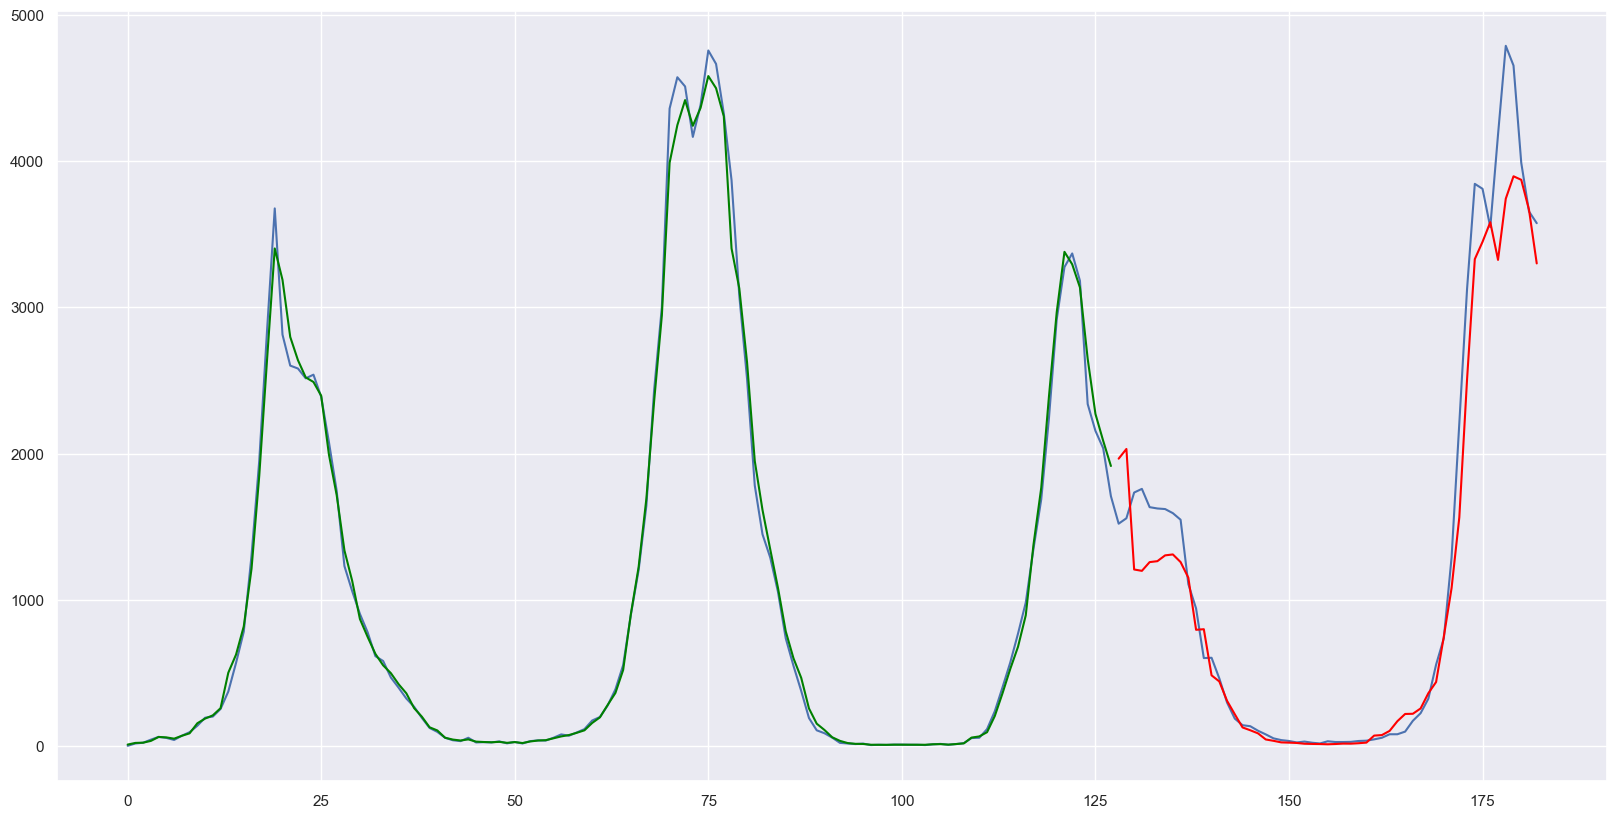

In [69]:
# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [70]:
preds_test_df.head()

,y1,y2,y3,y4
0,1965.61,1816.69,1731.74,1700.04
1,2031.95,1964.72,1924.23,1851.09
2,1207.75,1000.29,848.88,683.51
3,1198.44,1006.36,862.93,702.97
4,1258.20,1067.36,920.32,751.30


In [71]:
test_y.head()

,y1,y2,y3,y4
128,1521.0,1558.0,1734.0,1759.0
129,1558.0,1734.0,1759.0,1634.0
130,1734.0,1759.0,1634.0,1625.0
131,1759.0,1634.0,1625.0,1621.0
132,1634.0,1625.0,1621.0,1593.0


In [72]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 314.985 (116.355)


In [73]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 15232.838
RMSE_train: 122.252
MAE_train: 67.857
MSE_test: 230802.533
RMSE_test: 467.915
MAE_test: 277.822


# Random Forest with RandomizedSearchCV

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

parameters = {  
                'n_estimators':(80,100,120),
                'criterion':('squared_error', 'absolute_error', 'poisson'),
                'max_depth':(2,3,None),
                'min_samples_split':(2,3,4),
                'min_samples_leaf':(1,2,3),
                'min_weight_fraction_leaf':(0.0,0.1,0.2),
                'max_features':('sqrt', 'log2', None),
                'max_leaf_nodes':(5,10,None),
                'min_impurity_decrease':(0.0,0.1,0.2),
                # 'bootstrap':(True,False),
                # 'oob_score':(True,False),
                'n_jobs':([-1]),
                'random_state':([2022]),
                'ccp_alpha':(0.0,0.1,0.2),
                'max_samples':(10,20,None)
                }

rf = RandomForestRegressor()

model = RandomizedSearchCV(rf, parameters, random_state=2022, scoring='neg_root_mean_squared_error')

In [75]:
model.fit(train_X, train_y)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'ccp_alpha': (0.0, 0.1, 0.2),
                                        'criterion': ('squared_error',
                                                      'absolute_error',
                                                      'poisson'),
                                        'max_depth': (2, 3, None),
                                        'max_features': ('sqrt', 'log2', None),
                                        'max_leaf_nodes': (5, 10, None),
                                        'max_samples': (10, 20, None),
                                        'min_impurity_decrease': (0.0, 0.1,
                                                                  0.2),
                                        'min_samples_leaf': (1, 2, 3),
                                        'min_samples_split': (2, 3, 4),
                                        'min_weight_fraction_leaf': (0.0, 0.1,
                                                                     0.2),
                                        'n_estimators': (80, 100, 120),
                                        'n_jobs': [-1],
                                        'random_state': [2022]},
                   random_state=2022, scoring='neg_root_mean_squared_error')

In [76]:
model.best_params_

{'random_state': 2022,
 'n_jobs': -1,
 'n_estimators': 100,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.0,
 'max_samples': None,
 'max_leaf_nodes': None,
 'max_features': 'log2',
 'max_depth': None,
 'criterion': 'poisson',
 'ccp_alpha': 0.0}

In [77]:
preds_test = model.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = model.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

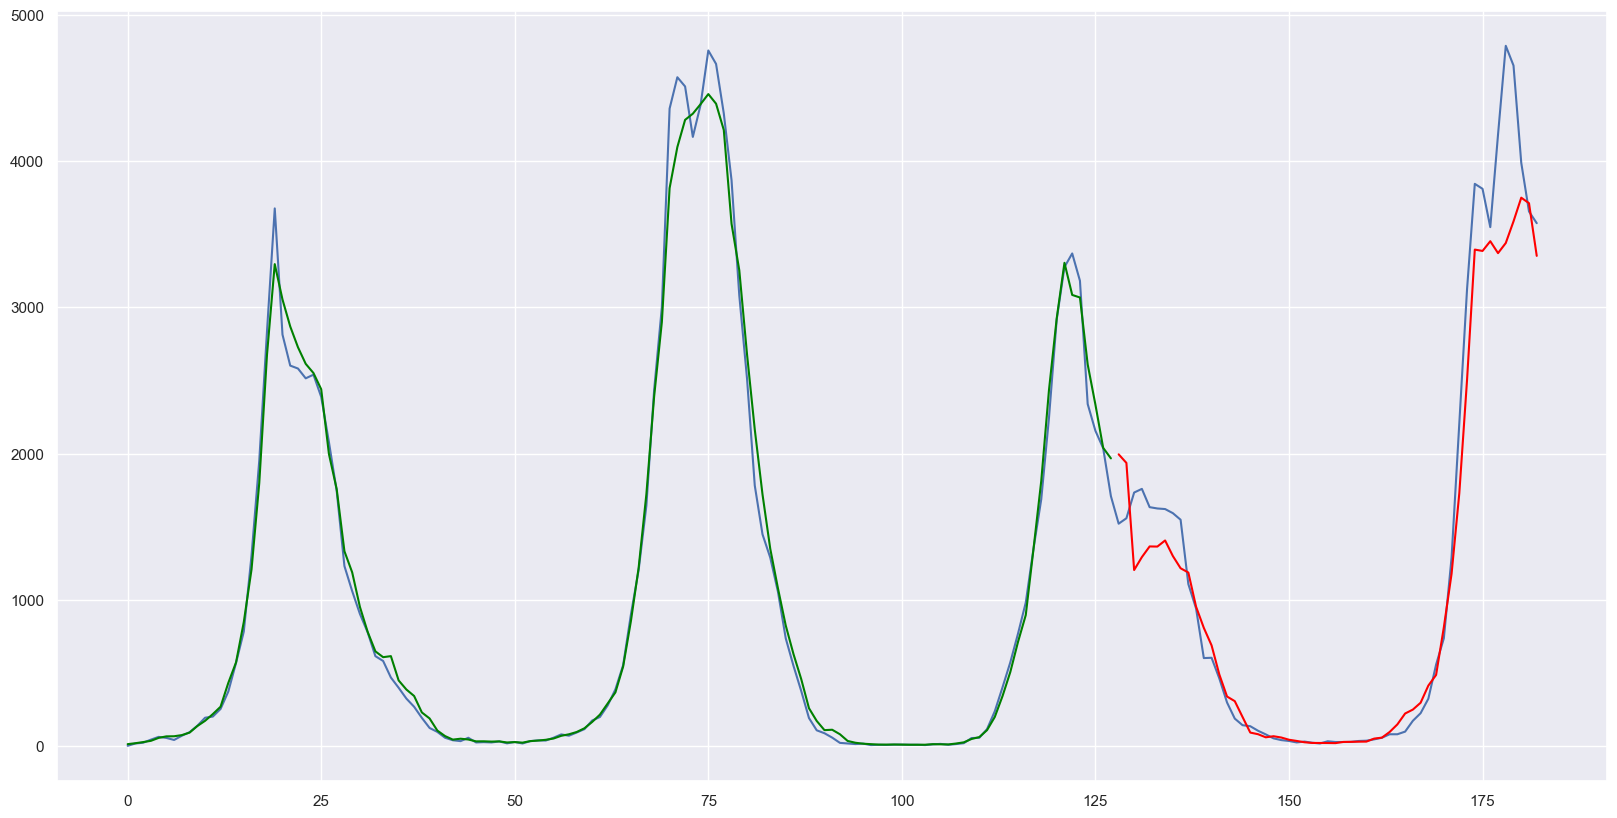

In [78]:
# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [79]:
preds_test_df.head()

,y1,y2,y3,y4
0,1995.244833,1800.942476,1674.043786,1618.090762
1,1936.605167,1758.349833,1588.344500,1513.394833
2,1204.124833,997.606500,826.187833,680.120500
3,1292.530000,1093.822083,925.302750,773.824917
4,1365.376167,1169.777167,1007.597833,856.567500


In [80]:
test_y.head()

,y1,y2,y3,y4
128,1521.0,1558.0,1734.0,1759.0
129,1558.0,1734.0,1759.0,1634.0
130,1734.0,1759.0,1634.0,1625.0
131,1759.0,1634.0,1625.0,1621.0
132,1634.0,1625.0,1621.0,1593.0


In [81]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 356.046 (160.867)


In [82]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 24143.23
RMSE_train: 153.92
MAE_train: 87.174
MSE_test: 231656.769
RMSE_test: 470.626
MAE_test: 279.261


# SVR - Direct Multioutput Regression

In [48]:
# define base model
model = LinearSVR()
# define the direct multioutput wrapper model
wrapper = MultiOutputRegressor(model)

In [49]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 1539.278 (445.027)


In [52]:
# fit the model on the whole dataset
wrapper.fit(train_X, train_y)

MultiOutputRegressor(estimator=LinearSVR())

In [53]:
preds_test = wrapper.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = wrapper.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

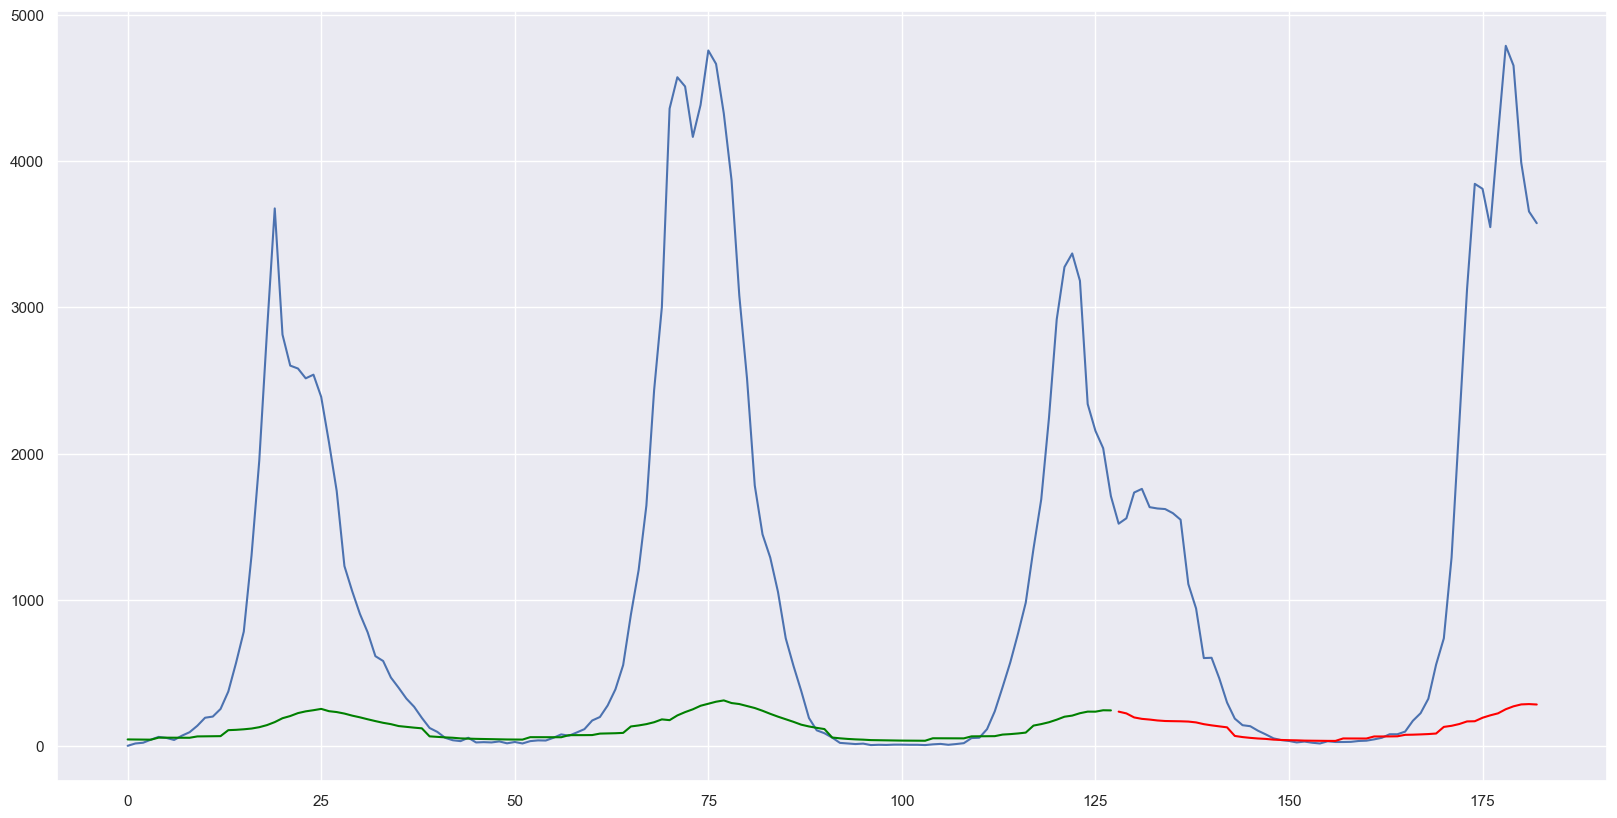

In [54]:
# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [55]:
preds_test_df.head()

,y1,y2,y3,y4
0,235.737795,235.887211,230.447382,224.905405
1,223.543904,223.881991,218.765915,213.560478
2,196.060792,194.648161,185.951573,177.198985
3,186.247204,185.094737,176.832653,168.533242
4,181.514642,180.470770,172.376753,164.255446


In [56]:
test_y.head()

,y1,y2,y3,y4
128,1521.0,1558.0,1734.0,1759.0
129,1558.0,1734.0,1759.0,1634.0
130,1734.0,1759.0,1634.0,1625.0
131,1759.0,1634.0,1625.0,1621.0
132,1634.0,1625.0,1621.0,1593.0


In [57]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 2531152.715
RMSE_train: 1590.906
MAE_train: 950.955
MSE_test: 3185788.344
RMSE_test: 1784.529
MAE_test: 1097.891


# SVR - Chained Multioutput Regression

In [59]:
# define base model
model = LinearSVR()
# define the direct multioutput wrapper model
wrapper = RegressorChain(model)

In [60]:
# define the evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate the model and collect the scores
n_scores = cross_val_score(wrapper, train_X, train_y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# force the scores to be positive
n_scores = absolute(n_scores)
# summarize performance
print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

RMSE: 1524.007 (435.862)


In [61]:
# fit the model on the whole dataset
wrapper.fit(train_X, train_y)

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RegressorChain(base_estimator=LinearSVR())

In [62]:
preds_test = wrapper.predict(test_X)
preds_test_df = pd.DataFrame(preds_test,columns=test_y.columns)
preds_train = wrapper.predict(train_X)
preds_train_df = pd.DataFrame(preds_train,columns=train_y.columns)

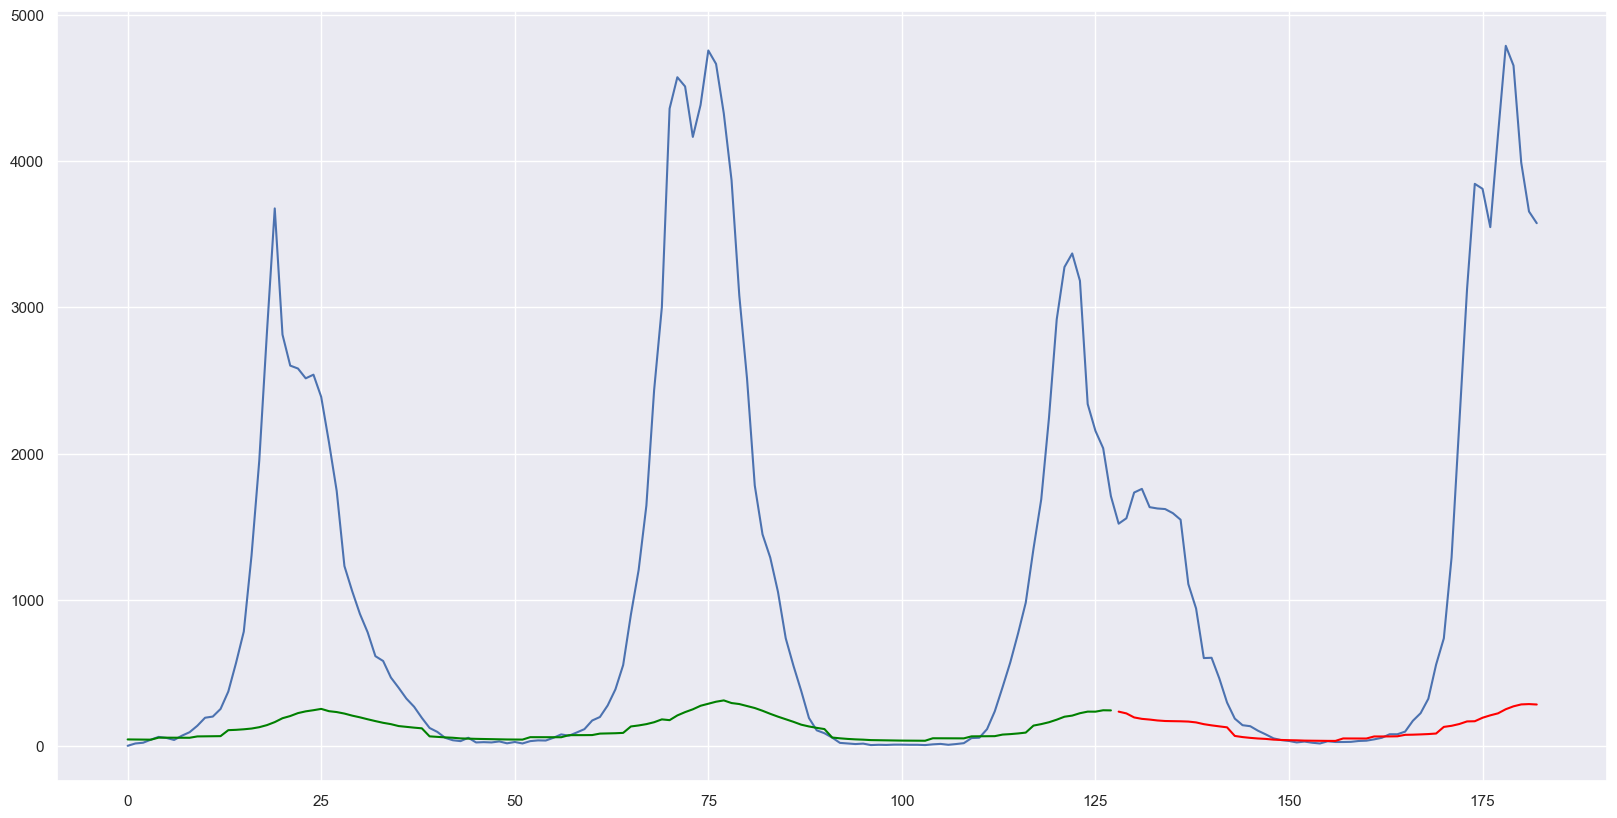

In [63]:
# plot
plt.plot(df_time_features_pre_COVID.index, df_time_features_pre_COVID['y1'].values)
plt.plot(df_time_features_pre_COVID.index[:train_size], preds_train_df['y1'], color='green')
plt.plot(df_time_features_pre_COVID.index[train_size:], preds_test_df['y1'], color='red')

In [64]:
preds_test_df.head()

,y1,y2,y3,y4
0,235.737795,311.655374,393.590236,492.847908
1,223.543904,296.226583,374.669255,469.839389
2,196.060792,244.846603,299.347037,367.296005
3,186.247204,233.075568,285.360865,350.612844
4,181.514642,227.332492,278.495290,342.402963


In [65]:
test_y.head()

,y1,y2,y3,y4
128,1521.0,1558.0,1734.0,1759.0
129,1558.0,1734.0,1759.0,1634.0
130,1734.0,1759.0,1634.0,1625.0
131,1759.0,1634.0,1625.0,1621.0
132,1634.0,1625.0,1621.0,1593.0


In [66]:
MSE_train = round(mean_squared_error(train_y, preds_train),3)
RMSE_train = round(mean_squared_error(train_y, preds_train, squared=False),3)
MAE_train = round(mean_absolute_error(train_y, preds_train),3)

print(f'MSE_train: {MSE_train}')
print(f'RMSE_train: {RMSE_train}')
print(f'MAE_train: {MAE_train}')

MSE_test = round(mean_squared_error(test_y, preds_test),3)
RMSE_test = round(mean_squared_error(test_y, preds_test, squared=False),3)
MAE_test = round(mean_absolute_error(test_y, preds_test),3)

print(f'MSE_test: {MSE_test}')
print(f'RMSE_test: {RMSE_test}')
print(f'MAE_test: {MAE_test}')


MSE_train: 2323814.439
RMSE_train: 1523.91
MAE_train: 905.952
MSE_test: 2948083.346
RMSE_test: 1716.847
MAE_test: 1050.353
